In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', 0)

In [372]:
owid = pd.read_csv('1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid[["location","date","reproduction_rate"]]
eu_response.head()

,Country,Response_measure,date_start,date_end
0,Austria,AdaptationOfWorkplace,2020-03-10,NaN
1,Austria,BanOnAllEvents,2020-11-03,NaN
2,Austria,ClosDaycare,2020-03-16,2020-05-04
3,Austria,ClosDaycarePartial,2020-11-17,2020-12-07
4,Austria,ClosHigh,2020-03-16,2020-09-30


In [373]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]
df.dropna(inplace=True)

In [374]:
# adding a column of all ones for beta_avg
try:
    df.insert(len(df.columns), "beta_avg", 1)
except ValueError:  # ValueError thrown if df already has that column
    pass

# initialize a column for each country type with all 0s
for country in eu_response["Country"].unique():
    try:
        df.insert(len(df.columns), country, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
# set the corresponding country to 1
for _, row in df.iterrows():
    df.loc[ df["location"] == row["location"] , row["location"]] = 1


# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
for _, row in eu_response.iterrows():
    df.loc[ ( df["location"] == row["Country"] ) & ( df["date"] >= row["date_start"] ) & ( df["date"] < row["date_end"] ), row["Response_measure"]] = 1

In [375]:
df

,location,date,reproduction_rate,beta_avg,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial
2837,Austria,2020-03-09,2.76,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2838,Austria,2020-03-10,2.84,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2839,Austria,2020-03-11,2.90,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2840,Austria,2020-03-12,2.95,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2841,Austria,2020-03-13,3.07,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2842,Austria,2020-03-14,2.93,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2843,Austria,2020-03-15,2.81,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2844,Austria,2020-03-16,2.68,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2845,Austria,2020-03-17,2.62,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2846,Austria,2020-03-18,2.52,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [376]:
df["location"].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [382]:
df_copy = df.copy()
df_copy[eu_response["Response_measure"].unique()] = df_copy.groupby("location")[eu_response["Response_measure"].unique()].shift(2).fillna(0)
df_copy[df_copy["location"] == "Austria"]

,location,date,reproduction_rate,beta_avg,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial
2837,Austria,2020-03-09,2.76,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2838,Austria,2020-03-10,2.84,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2839,Austria,2020-03-11,2.90,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2840,Austria,2020-03-12,2.95,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2841,Austria,2020-03-13,3.07,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2842,Austria,2020-03-14,2.93,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2843,Austria,2020-03-15,2.81,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

In [316]:
# prepare data and divide train & test set
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# later we can do a different split

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])
print(clf.coef_)
print(clf.intercept_)

In [425]:
# for given (tau, alpha), return the testing score
def LASSO_alpha_tau(tau, alp):
    # Data processing: shift by tau
    df_copy = df.copy()
    df_copy[eu_response["Response_measure"].unique()] = df_copy.groupby("location")[eu_response["Response_measure"].unique()].shift(tau).fillna(0)
    
    # Split training and testing data
    train, test = train_test_split(df_copy, test_size=0.2)
    idx_data = ["beta_avg"] + list( eu_response["Country"].unique() ) + list( eu_response["Response_measure"].unique())
    idx_target = "reproduction_rate"
    Xtrain = train[idx_data]
    Ytrain = train[idx_target]   
    Xtest = test[idx_data]
    Ytest = test[idx_target]
    
    # LASSO
    clf = linear_model.Lasso(alpha=alp)
    clf.fit(Xtrain, Ytrain)
    
    #print(clf.coef_)
    #print(clf.intercept_)
    
    # return testing score
    score = clf.score(Xtest, Ytest)
    return score

In [424]:
LASSO_alpha_tau(20, 1e-3)

[ 0.         -0.00242076  0.0473539  -0.         -0.01765401 -0.
  0.11409118 -0.         -0.0639825  -0.02021782  0.05651407  0.04079186
 -0.          0.         -0.20530564  0.10114837  0.16531186 -0.
 -0.16420611  0.          0.00034254 -0.28625879  0.14453746 -0.06464416
  0.          0.01660446 -0.         -0.         -0.0070291   0.09571207
 -0.00813482  0.          0.18044982 -0.0551321  -0.02661733 -0.06231958
 -0.          0.01498475 -0.09025332 -0.         -0.04923328 -0.0571544
 -0.01733019 -0.10559048 -0.07607355 -0.03988732 -0.         -0.02571369
 -0.04669312 -0.08436828 -0.08866845 -0.02712078 -0.05322048  0.02101984
  0.         -0.0521457  -0.         -0.          0.00271711 -0.01311152
  0.04346151  0.00818095 -0.04232247  0.00330947  0.         -0.00730743
 -0.         -0.11308738 -0.         -0.          0.         -0.04410131
 -0.04746955 -0.          0.         -0.05827616 -0.         -0.
  0.04287221 -0.10545726 -0.         -0.         -0.29164051 -0.
 -0.0580388

In [432]:
TAU_RANGE = 60
test_score = []
for tau in range(0,TAU_RANGE):    
    test_score = test_score + [LASSO_alpha_tau(tau, 1e-3)]

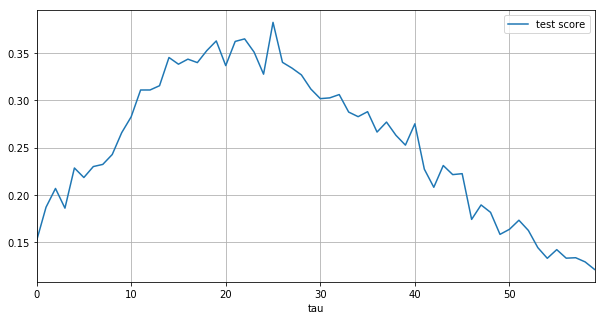

In [433]:
score_by_tau = pd.DataFrame({'tau':range(0,TAU_RANGE),'test score':test_score})
score_by_tau.set_index('tau').plot(figsize=(10,5), grid=True)
plt.show()

In [ ]:
# Bayesian Optimization
# range of tau and alpha
# call LASSO_alpha_tau


In [420]:
N_c = len(eu_response["Country"].unique())
N_r = len(eu_response["Response_measure"].unique())
N_c, N_r

(32, 64)